In [3]:
# Import all modules you will use
import torch # pip install 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms # pip install 
import numpy as np
from matplotlib import pyplot as plt
import torch.nn.functional as F

In [4]:
# Load in the dataset

pick = datasets.MNIST(root='./data', train=True, download=True)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())#This specifies that we want the test part of the MNIST dataset.
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

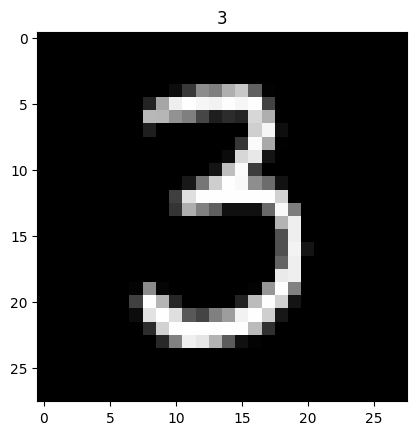

In [5]:
image, label = pick[50] 

plt.imshow(image, cmap="gray")
plt.title(f"{label}")
plt.show()

In [6]:
train_dataset[1]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
# Data cleaning or for NN - work on transforming the data
 #Takes list of Transformations & composes them into single trans(Applied in order). Converts images into tensors. Then normalizes tensor images.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) 



In [8]:
# Create Data Loaders on the data to make it easy to feed data to the model in batches.


#make the data loaders

# Loads data in shuffled batches of 64 samples. Reduces overfitting.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Define a class to be the NN model (must have an __init__ and a forward function)
# init the nn class with an init function and a forward pass
class Net(nn.Module):                      # Defines a new class Net that inherits from nn.Module
    def __init__(self):  
        super(Net, self).__init__()  
        self.fc1 = nn.Linear(28*28, 512)   # Input: 28x28 image, Hidden layer: 512 neurons
        self.fc2 = nn.Linear(512, 10)     # Output: 10 classes (digits 0-9)
  
    def forward(self, x):                 # specifies how the input data flows through the network layers.
        x = x.view(-1, 28*28)             # Flatten the image (Removes some of the dimensions)
        x = F.relu(self.fc1(x))         # May not always be the same. ReLU is reliable. 
        x = self.fc2(x)                #   Passes the output from the previous layer to the second fully connected layer fc2
        return x                      #   Returns the final output of the network.

In [10]:
# Initilize the model
model = Net()


In [11]:
# Set the loss function
criterion = nn.CrossEntropyLoss() # BCEWithLogitsLoss could be used as well. 


In [12]:
# Set the optimizer function (Brett used "Adam") # could use SGD as well. 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Define the training loop then and print the progress for the loop either every epoch or every 5 or 10 epochs. 
for epoch in range(10): # where I left off @ me
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    #the song says "print out whats happening"
    print(f'Epoch {epoch}: Loss: {loss.item():.4f}')

Epoch 0: Loss: 0.1448
Epoch 1: Loss: 0.0311
Epoch 2: Loss: 0.0391
Epoch 3: Loss: 0.0193
Epoch 4: Loss: 0.0075
Epoch 5: Loss: 0.0761
Epoch 6: Loss: 0.0200
Epoch 7: Loss: 0.0181
Epoch 8: Loss: 0.0001
Epoch 9: Loss: 0.0005


In [14]:
# Evaluate the model with the ".eval()" function
# Calulate the avergae loss and accuracy and print out the results
model.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
with torch.no_grad():  # No gradients needed during evaluation
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

Test Loss: 0.0012, Accuracy: 98.03%
